# <center> Random Walk Kernel </center>

 

In this notebook you can find the implementation of 3 versions of the Random Walk Kernel (RWK), the necessary product graph, and the implementation of SVM for binary classification, and some of the experiments we did.
The three versions of the RWK differ on the data that take into account: the first does not take into account any label of the nodes or edges, the second takes into account the labels in the nodes, and the third one takes into account, both the nodes' labels and the edges' labels. 

# 0.Import data

In [1]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np
import scipy
import mgzip

In [2]:

with open('./data-challenge-kernel-methods-2022-2023/test_data.pkl', 'rb') as f:
    challenge_data = pickle.load(f)
    
with open('./data-challenge-kernel-methods-2022-2023/training_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
    
with open('./data-challenge-kernel-methods-2022-2023/training_labels.pkl', 'rb') as f:
    train_label = pickle.load(f)


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.3, random_state=42)

In [4]:
def visualize_graph(graph, label):
    '''
    Allows us to visualize the graph with the edge and node labels.
    
    :param graph: networkx object with labeled nodes and edges.
    :param label: label/category of the graph
    '''
    my_pos = nx.spring_layout(graph, seed = 1032023, scale=0.5)
    print(f'Graph with label: {label}')

    labels_nodes = {key:value[0] 
                    for (key,value) 
                    in nx.get_node_attributes(graph, 'labels').items()}
    
    labels_edges = {key:value[0] 
                    for (key,value) 
                    in nx.get_edge_attributes(graph, 'labels').items()}
    
    nx.draw(graph, pos = my_pos,labels =labels_nodes, with_labels=True, node_size=500)

    nx.draw_networkx_edge_labels(graph, my_pos, edge_labels=labels_edges, font_color='red')
    
    plt.show()
 

# 1. Implementing Walk Kernels

The product graph needed for the Random walk kernel is the so-called 'Tensir product of graph' or 'Direct product'. Consider G,H graphs and GxH the product. 

This graph has the property that the adjancecy matrix is the Kronecker (tensor) product of the adjacency matrices of G and H (with a possible transformation). (wikipedia).

Assume A has n nodes and B has m nodes, the adjacency matrix of $A\times B$ will have nm nodes. Enumerating the nodes of $A\times B$ as 1=(A1,B1), 2=(A1,B2),..., m = (A1,Bm)... we dont need to further transform the adjacency matrix, it will just be the Kronecker product. 

Then, node k of $A\times B$ will correspond to $k = (A\{(k-(k\%m))/m\}, B\{k\%m\})$ or $k=(A\{(k-(k\%m))/m\}, B\{m\})$ if k%m=0.

Since our data is labeled, we will implement the possibility to remove the nodes where the label of the corresponding nodes in G and H do not have the same label.



## 1.1. Implementing graph product

In [5]:
import networkx as nx 
import numpy as np
import scipy

class ProductGraph:
    '''
    Direct product graph. 
    Functions in this version take adjacency matrices and dictionaries with labels objects.
    
    Contains two functions, one for labeled nodes and one for unlabeled nodes.
    They allow to return a graph object or the adjacency matrix.
    It's the version needed for the random walk kernel.
    
    '''
    def __init__(self):
        pass
        
    def labeled_nodes(self,G1, G2, return_nx = False):
        '''
        Direct product graph (aka Tensor Product of Graph).
        Assumes graphs have attribute 'labels' for each node.
        Also assumes nodes in the graphs are numbered starting from 0.
        These properties appear to be true in our dataset.
        Does not take into account labeled edges.
        
        Will return only adjacency matrix of the product by default. 
        
        If return_nx is True, a networkx object with labeled nodes will be returned
        
        _Parameters_
        :param adj_G1, adj_G2: adjacency matrices 
        :param labels_1,  labels_2: dictionaries with the numbers of the nodes and the labels 
        '''

        #obtain adjacency matrix and dictionaries with labels from graphs
        adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix 
        labels_1 = nx.get_node_attributes(G1, 'labels')

        adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix 
        labels_2 = nx.get_node_attributes(G2, 'labels')
            
        n = adj_G1.shape[0]

        m = adj_G2.shape[0]

        adj_prod = scipy.sparse.kron(adj_G1,adj_G2,format='csr') #adjacency matrix of the simple product graph
         # create graph from adjacency matrix

        k = adj_prod.shape[0]
        
        if k==0:
            return np.empty(0) 
        if return_nx:
            #Here we want to put the label in the product graph, so we take advantage of
            #the structure of the nx graph object
            prodG = nx.from_scipy_sparse_array(adj_prod)
            for i in range(1, k+1):
                #Corresponding nodes in G1 and G2 to node i in the product
                node_1 =  (i-(i%m))/m +1 if i%m!=0 else (i-(i%m))/m 
                node_2 = i%m if i%m!=0 else m

                #Remove node in product if labels are different, set label otherwise
                if labels_1[node_1-1]!=labels_2[node_2-1]:
                    prodG.remove_node(i-1)
                else:
                    nx.set_node_attributes(prodG, {i-1:labels_1[node_1-1]}, 'labels')
            return prodG
        
        else: 
            #We try to work only with matrices to work more efficiently.
            # However going from matrix to sparse and/or viceversa might be costly
            
            #I checked and this is faster than dealing with the networkx graph and the retreiving its adjacency matrix
            
            nodes_to_remove =[]
            for i in range(1, k+1):
                #Corresponding nodes in G1 and G2 to node i in the product
                node_1 =  (i-(i%m))/m +1 if i%m!=0 else (i-(i%m))/m 
                node_2 = i%m if i%m!=0 else m

                #Remove node in product if labels are different, set label otherwise
                if labels_1[node_1-1]!=labels_2[node_2-1]:
                    nodes_to_remove.append(i-1)
                    
            adj_prod = adj_prod.toarray()
            adj_prod=np.delete(arr = adj_prod, obj = nodes_to_remove,axis = 0)
            adj_prod=np.delete(arr = adj_prod, obj = nodes_to_remove,axis = 1)
            
            return adj_prod

            
    def unlabeled(self,G1,G2,return_nx = False):
        '''
        Direct product graph (aka Tensor Product of Graph).
        
        Here we do not take into account the labels of the graph.
        
        It returns the adjacency matrix of the product.
        ! It is a scipy sparse matrix
        '''

        #obtain adjacency matrix from graphs
        adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix 
        adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix 
  
        adj_prod = scipy.sparse.kron(adj_G1,adj_G2) #adjacency matrix of the simple product graph
        
        if return_nx:
            return nx.from_scipy_sparse_array(adj_prod)
        else:
            return adj_prod
        
        
    def labeled_edges(self,G1, G2, return_nx = False):
        '''
        Direct product graph (aka Tensor Product of Graph) taking into account labeled
        nodes and edges.
        Assumes graphs have attribute 'labels' for each node and for each edge.
        Also assumes nodes in the graphs are numbered starting from 0.
        These properties appear to be true in our dataset.

        Will return only adjacency matrix of the product by default. 
        
        If return_nx is True, a networkx object with labeled nodes will be returned
        
        _Parameters_
        :param adj_G1, adj_G2: adjacency matrices 
        :param labels_1,  labels_2: dictionaries with the numbers of the nodes and the labels 
        '''

        #obtain adjacency matrix and dictionaries with labels from graphs
        adj_G1 = nx.adjacency_matrix(G1)
        adj_G2 = nx.adjacency_matrix(G2)
        node_labels_1 = nx.get_node_attributes(G1, 'labels')
        node_labels_2 = nx.get_node_attributes(G2, 'labels')
        
        n = adj_G1.shape[0]

        m = adj_G2.shape[0]

        
        adj_prod = scipy.sparse.kron(adj_G1,adj_G2,format='csr')
        
        # TODO We have to deal with labeled nodes returning 0
                
        if return_nx:
            prod =  self.labeled_nodes(G1, G2, return_nx = True)

            # TODO We have to deal with labeled nodes returning 0
            
            to_remove = []

            for edge in prod.edges(data=True):
                #Corresponding nodes in G1 and G2 to node i in the product
                start = edge[0]+1
                end = edge[1]+1
                start_1 =  (start-(start%m))/m +1 if start%m!=0 else (start-(start%m))/m 
                start_2 = start%m if start%m!=0 else m
                end_1 =  (end-(end%m))/m +1 if end%m!=0 else (end-(end%m))/m 
                end_2 = end%m if end%m!=0 else m

                #print('p', start,end)
                #print('G1', start_1, end_1)
                #print('G2', start_2, end_2)

                label_1 = G1.get_edge_data(start_1-1, end_1-1)['labels']
                label_2 = G2.get_edge_data(start_2-1, end_2-1)['labels']

                #Remove node in product if labels are different, set label otherwise
                if label_1!=label_2:
                    to_remove.append((start-1, end-1))
                else:
                    nx.set_edge_attributes(prod, {(start-1, end-1):label_1}, 'labels')

            prod.remove_edges_from(to_remove)
            #prod.remove_nodes_from(list(nx.isolates(prod)))

            return prod

        else: 
            edges_to_remove = []
            nodes_to_remove =[]

            cx = adj_prod.tocoo()
            
            for start,end in zip(cx.row, cx.col):
                start +=1
                end +=1
                start_1 =  (start-(start%m))/m +1 if start%m!=0 else (start-(start%m))/m 
                start_2 = start%m if start%m!=0 else m
                end_1 =  (end-(end%m))/m +1 if end%m!=0 else (end-(end%m))/m 
                end_2 = end%m if end%m!=0 else m

                label_1 = G1.get_edge_data(start_1-1, end_1-1)['labels']
                label_2 = G2.get_edge_data(start_2-1, end_2-1)['labels']

                #Remove node in product if labels are different, set label otherwise
                if label_1!=label_2:
                    edges_to_remove.append((start-1, end-1))

                if node_labels_1[start_1-1]!=node_labels_2[start_2-1]:
                    nodes_to_remove.append(start-1)

                if node_labels_1[end_1-1]!=node_labels_2[end_2-1]:
                    nodes_to_remove.append(end-1)

            adj_prod = adj_prod.toarray()

            for edge in edges_to_remove:
                adj_prod[edge[0],edge[1]]=0
                adj_prod[edge[1],edge[0]]=0

            adj_prod=np.delete(arr = adj_prod, obj = nodes_to_remove,axis = 0)
            adj_prod=np.delete(arr = adj_prod, obj = nodes_to_remove,axis = 1)

            return adj_prod
            

### Checking Product Graph

Graph with label: 0


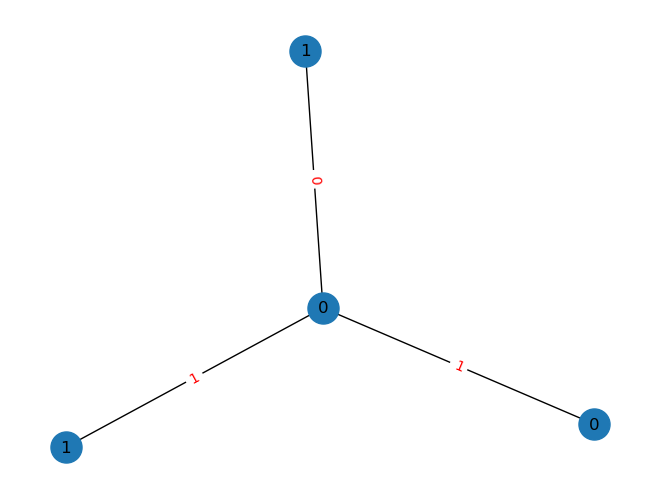

Graph with label: 0


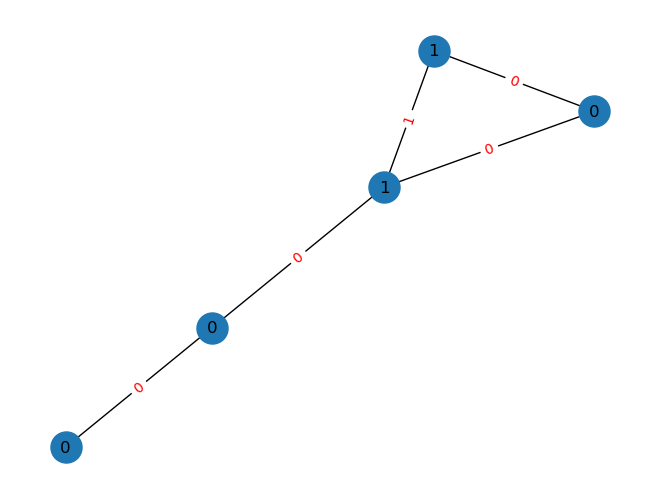

In [6]:
A = nx.Graph()
A.add_nodes_from([(0, {'labels': [0]}),
                 (1, {'labels': [0]}),
                 (2, {'labels': [1]}),
                 (3, {'labels': [1]})])

A.add_edges_from([(0, 1,{'labels': [1]}),
                  (1, 2,{'labels': [1]}),
                  (1, 3,{'labels': [0]})])

B = nx.Graph()
B.add_nodes_from([(0, {'labels': [0]}),
                 (1, {'labels': [0]}),
                 (2, {'labels': [1]}),
                 (3, {'labels': [0]}),
                 (4, {'labels': [1]})])

B.add_edges_from([(0,1, {'labels': [0]}),
                 (1,2, {'labels': [0]}),
                 (2,3, {'labels': [0]}),
                 (2,4, {'labels': [1]}),
                 (4,3, {'labels': [0]})])


visualize_graph(A, y_train[0])
visualize_graph(B, y_train[0])



**Checking Product Graph with Labeled Nodes**

[(0, {'labels': [0]}), (1, {'labels': [0]}), (3, {'labels': [0]}), (5, {'labels': [0]}), (6, {'labels': [0]}), (8, {'labels': [0]}), (12, {'labels': [1]}), (14, {'labels': [1]}), (17, {'labels': [1]}), (19, {'labels': [1]})]
Graph with label: 0


/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/3037087972.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_A = nx.adjacency_matrix(A)
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/3037087972.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_B = nx.adjacency_matrix(B)
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:36: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:39: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix


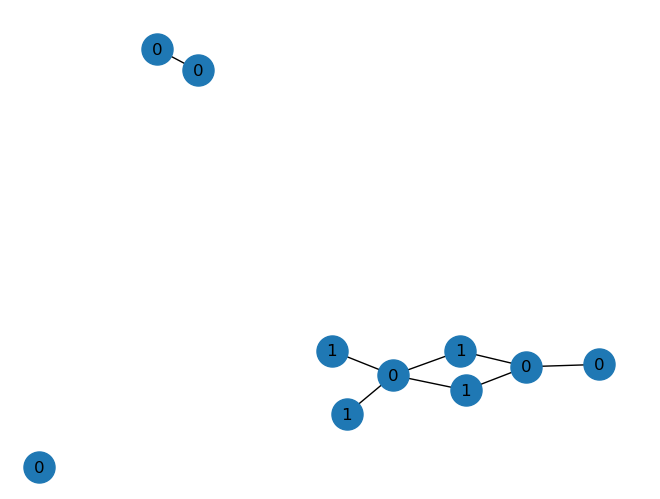

In [7]:
adj_A = nx.adjacency_matrix(A)
adj_B = nx.adjacency_matrix(B)
labels_A = nx.get_node_attributes(A, 'labels')
labels_B = nx.get_node_attributes(B, 'labels')
prod = ProductGraph().labeled_nodes(A,B,return_nx = True)
print(list(prod.nodes(data=True)))
visualize_graph(prod, y_train[0])


**Checking Product Graph with Labeled Nodes and Edges**


Graph with label: 0


/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:132: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1)
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:133: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2)
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:36: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:39: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix


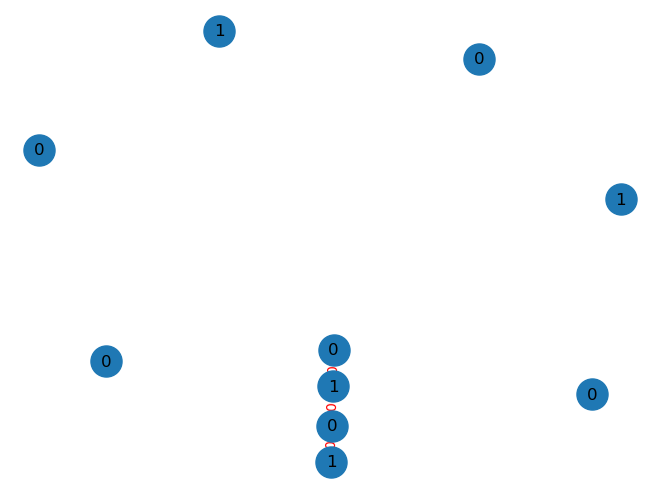

In [8]:
prod2 = ProductGraph().labeled_edges(A,B, return_nx = True)
visualize_graph(prod2, y_train[0])

## 1.2. Unlabeled Random Walk Kernel for graphs 

In [9]:
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import LinearOperator

We will do an implementation of the random walk kernel using Conjugate Gradient Method proposed by [Graph Kernels 2010, Vishwanathan et al]
We solve (I-lambda*A)X = p using the cg method from scipy.sparse.linalg, but using the formula from the paper to compute Ax.
With their notation, letting A be de adjacency matrix of the product graph, and $A_1$ and $A_2$ of the original graphs, it follows

$$
(I-\lambda A)x = Ix-\lambda vec(A_2  X  A_1^T)
$$

where, if B is a matrix of size $n\times m$ $vec(B)$ is the vector of size $nm$ resulting from stacking itss columns.

In [10]:
from tqdm import tqdm

class Random_Walk_Kernel:
    def __init__(self, weight = 0.1, method='cg', verbose = True):
        self.weight = weight
        self.method = method
        self.verbose = verbose
    
    def kernel_simple(self,G1,G2):
        '''
        Computes kernel function for 2 graphs
        
        
        If p and q are the vectors with the starting and stopping probabilities respectively, computing the 
        random walk kernel amounts to computing q^T(I-lambda*A)^{-1}p where A is the adjacency matrix of the product graph.
        
        We consider uniform starting and stopping distributions (i.e. probability 1/n where n is the number of vertices).
       
        '''
        nm=0
        
        if self.method == 'direct':
            prod = ProductGraph().unlabeled(G1,G2)
            nm = prod.shape[0] #Number of nodes in product graph

            if nm!=0: output= np.ones(nm).T@scipy.sparse.linalg.spsolve(scipy.sparse.eye(nm)-self.weight*prod,np.ones(nm)) 
            
            #Can be normalized using the following line instead
            #if nm!=0: output= (1/nm)*np.ones(nm).T@np.linalg.solve(np.eye(nm)-self.weight*prod.toarray(),np.ones(nm)) #direct inverse
            
        elif self.method== 'cg': #Efficient implementation using Conjugate Gradient Methods [Graph Kernels 2010, Vishwanathan et al]
            # However, this implementation seem not to be faster than the other and results are not exactly the same
            adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix 
            adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix 
            
            n = adj_G1.shape[0]
            m = adj_G2.shape[0]
            nm = m*n

            def mv(x):
                X  = x.reshape(n,m)
                vec = adj_G1@X@adj_G2.T
                vec = np.hstack(vec[:, i] for i in range(vec.shape[1]))
                return x -self.weight*vec

            M = LinearOperator((nm,nm),matvec=mv)

            #The solution of the linear system is (I-lambda*A)^{-1}p 
            sol = cg(M,np.ones(nm),tol=1.0e-3, maxiter=20)[0]

            #could be normalized using output = (1/nm)*sol.sum()
            output = sol.sum()

            
        if nm==0 : return 0 #in this case the matrices have no vertices in common
        else: return output
        
    
    def kernel_matrix (self, G):
        '''
        Computes kernel matrix for a list of graphs.
        
        '''
        n = len(G)
        
        K = np.zeros((n,n))
        
        for i in tqdm(range(n)):
            for j in range(i,n):
                K[i][j] = self.kernel_simple(G[i], G[j])
                if i!=j:
                    K[j][i]= K[i][j]
   
        return K

    def kernel(self,G1,G2):
        '''
        Computes pairwise kernel comparisons between two lists of graphs.
        '''
        n = len(G1)
        m = len(G2)
        K = np.zeros((n,m))
        
        
        for i in range(n):
            for j in range(m):
                K[i][j] = self.kernel_simple(G1[i], G2[j])
                    
        return K

In [11]:
#Our implementation, direct method
Random_Walk_Kernel(method='direct').kernel_matrix(X_train[:3])

  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:103: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:104: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix
100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


array([[650.60431749, 763.33818215, 431.02949113],
       [763.33818215, 900.57957674, 503.80963139],
       [431.02949113, 503.80963139, 287.36141907]])

In [12]:
#Our implementation, cg method
Random_Walk_Kernel(method='cg').kernel_matrix(X_train[:3])

  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/2150432073.py:33: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/2150432073.py:34: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/2150432073.py:43: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vec = np.hstack(vec[:, i] for i in range(vec.shape[1]))
100%|██████████| 3/3 [00:00<00:00, 181.34it/s]


array([[650.60404946, 629.63969514, 368.82017157],
       [629.63969514, 900.5795648 , 434.68328049],
       [368.82017157, 434.68328049, 287.36141907]])

**Discussion on the results**

We observe that the method 'direct' (not normalizing) and the 'cg' method do not give exactly the same results, only values in the diagonal coincide. We may assume that the correct results are the one from the direct method as it applied directly the definition, while the 'cg' method approximates.

**Discussion on performance (time)**
Below, we observe that creating the kernel matrix for 200 graphs with the 'direct method' takes (in my computer) 22 seconds, but with the 'cg' method takes over 50. We assume that the advantage of this method might be observed in the labaled scenario.

In [13]:
Random_Walk_Kernel(method='direct').kernel_matrix(X_train[:200])

  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:103: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:104: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix
100%|██████████| 200/200 [00:22<00:00,  8.77it/s]


array([[ 650.60431749,  763.33818215,  431.02949113, ...,  305.22142153,
         982.80596624,  431.51930214],
       [ 763.33818215,  900.57957674,  503.80963139, ...,  354.69428457,
        1151.65421939,  504.2963574 ],
       [ 431.02949113,  503.80963139,  287.36141907, ...,  205.00782918,
         652.07033071,  287.7051903 ],
       ...,
       [ 305.22142153,  354.69428457,  205.00782918, ...,  147.72      ,
         462.72842439,  205.3470386 ],
       [ 982.80596624, 1151.65421939,  652.07033071, ...,  462.72842439,
        1485.58029125,  652.77872328],
       [ 431.51930214,  504.2963574 ,  287.7051903 , ...,  205.3470386 ,
         652.77872328,  288.16148159]])

In [14]:
Random_Walk_Kernel(method='cg').kernel_matrix(X_train[:200])

  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/2150432073.py:33: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/2150432073.py:34: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/2150432073.py:43: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vec = np.hstack(vec[:, i] for i in range(vec.shape[1]))
100%|██████████| 200/200 [00:50<00:00,  4.00it/s]


array([[ 650.60404946,  629.63969514,  368.82017157, ...,  267.80601624,
         846.40020634,  379.90588674],
       [ 629.63969514,  900.5795648 ,  434.68328049, ...,  310.1687502 ,
         950.16161077,  427.59850621],
       [ 368.82017157,  434.68328049,  287.36141907, ...,  182.46648075,
         562.00105543,  249.87338484],
       ...,
       [ 267.80601624,  310.1687502 ,  182.46648075, ...,  147.72      ,
         412.0463591 ,  177.11549871],
       [ 846.40020634,  950.16161077,  562.00105543, ...,  412.0463591 ,
        1485.58009621,  584.4783291 ],
       [ 379.90588674,  427.59850621,  249.87338484, ...,  177.11549871,
         584.4783291 ,  288.16146418]])

## 1.3. Labeled Nodes Random Walk Kernel

In [15]:
from tqdm import tqdm

class Labeled_Random_Walk_Kernel:
    def __init__(self, weight = 0.1, method = 'direct'):
        self.weight = weight
        self.method = method
    
    def kernel_simple(self,G1,G2):
        '''
        Computes kernel function for 2 graphs
        '''
        
        if self.method == 'direct': 

            prod = ProductGraph().labeled_nodes(G1,G2, return_nx = False)

            # I ckecked, and converting to sparse matrix and then using sparse solver is faster than keeping it as np.ndarray and using np.linalg solver
            prod = scipy.sparse.csr_matrix(prod) 

            nm = prod.shape[0] #Number of nodes in product graph

            if nm!=0: 
                output= np.ones(nm).T@scipy.sparse.linalg.spsolve(scipy.sparse.eye(nm)-self.weight*prod,np.ones(nm)) #direct inverse
            else:
                output=0
        elif self.method == 'cg':
            #To Be Implemented
            
            output=0

        #Can be normalized using the following line instead
        #if nm!=0: output= (1/nm)*np.ones(nm).T@np.linalg.solve(np.eye(nm)-self.weight*prod.toarray(),np.ones(nm)) #direct inverse
        
        return output
        
    def kernel_matrix (self, G):
        '''
        Computes kernel matrix for a list of graphs.
        
        '''
        n = len(G)
        
        K = np.zeros((n,n))
        
        for i in tqdm(range(n)):
            for j in range(i,n):
                K[i][j] = self.kernel_simple(G[i], G[j])
                if i!=j:
                    K[j][i]= K[i][j]
   
        return K

    def kernel(self,G1,G2):
        '''
        Computes pairwise kernel comparisons between two lists of graphs.
        '''
        n = len(G1)
        m = len(G2)
        K = np.zeros((n,m))
        
        
        for i in tqdm(range(n)):
            for j in range(m):
                K[i][j] = self.kernel_simple(G1[i], G2[j])
                    
        return K

In [16]:
Labeled_Random_Walk_Kernel().kernel_matrix(X_train[:150])

  0%|          | 0/150 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:36: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:39: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix
100%|██████████| 150/150 [00:16<00:00,  9.12it/s]


array([[572.57395736, 158.29015781, 186.81729403, ..., 514.13050281,
        511.23608046, 408.65594523],
       [158.29015781, 324.99847179,  54.72527473, ..., 152.64221192,
        147.52081958, 127.0030377 ],
       [186.81729403,  54.72527473, 109.83050847, ..., 186.73771065,
        211.14851819, 184.53455696],
       ...,
       [514.13050281, 152.64221192, 186.73771065, ..., 487.73209796,
        482.50981464, 409.17282694],
       [511.23608046, 147.52081958, 211.14851819, ..., 482.50981464,
        504.38589498, 417.57354766],
       [408.65594523, 127.0030377 , 184.53455696, ..., 409.17282694,
        417.57354766, 393.13719777]])

**Discussion**

Even if it is a bit slower, with the right modifications we have achieved fir the kernel matrix to be computed in reasonable time for our train data set (around 5 hours).

There is a way to implement conjugate gradients for labeled graphs, but in this case we don't work with the adjacency matrices. We could try to implement it. It is also based on solving $Ix-\lambda vec(A_2  X  A_1^T)=p$ but $A_1, A_2$ are not the adjacency matrices. Instead they are the $\phi(X)$ detailed at the begining of page 1206 in https://www.jmlr.org/papers/volume11/vishwanathan10a/vishwanathan10a.pdf.
Observe that in this paper they think of labeled edges, so in order to take into account the labeled vertices we can consider each edge as labeled with the labels of the nodes in its ends.
If we implemented this we could probably easily take into account edge-labels.
Finally we could take into account edges+labels considering the edges labeled by its own label= the labels of its nodes.


## 1.4. Labeled Nodes and Edges RMK

In [17]:
from tqdm import tqdm

class Labeled__Edges_RW_Kernel:
    def __init__(self, weight = 0.1, method = 'direct'):
        self.weight = weight
        self.method = method
    
    def kernel_simple(self,G1,G2):
        '''
        Computes kernel function for 2 graphs
        '''
        
        if self.method == 'direct': 
            
            prod = ProductGraph().labeled_edges(G1,G2, return_nx = False)
            
            nm = prod.shape[0]
        
            if nm!=0: 
                prod = scipy.sparse.csr_matrix(prod) 
                output= np.ones(nm).T@scipy.sparse.linalg.spsolve(scipy.sparse.eye(nm)-self.weight*prod,np.ones(nm)) #direct inverse
            else:
                output=0
        elif self.method == 'cg':
            #To Be Implemented
            
            output=0

        #Can be normalized using the following line instead
        #if nm!=0: output= (1/nm)*np.ones(nm).T@np.linalg.solve(np.eye(nm)-self.weight*prod.toarray(),np.ones(nm)) #direct inverse
        
        return output
        
    def kernel_matrix (self, G):
        '''
        Computes kernel matrix for a list of graphs.
        
        '''
        n = len(G)
        
        K = np.zeros((n,n))
        
        for i in tqdm(range(n)):
            for j in range(i,n):
                K[i][j] = self.kernel_simple(G[i], G[j])
                if i!=j:
                    K[j][i]= K[i][j]
   
        return K

    def kernel(self,G1,G2):
        '''
        Computes pairwise kernel comparisons between two lists of graphs.
        '''
        n = len(G1)
        m = len(G2)
        K = np.zeros((n,m))
        
        
        for i in tqdm(range(n)):
            for j in range(m):
                K[i][j] = self.kernel_simple(G1[i], G2[j])
                    
        return K

In [18]:
Labeled__Edges_RW_Kernel().kernel_matrix(X_train[:150])

  0%|          | 0/150 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:132: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1)
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_49898/365156290.py:133: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2)
100%|██████████| 150/150 [01:24<00:00,  1.77it/s]


array([[489.95602991, 151.73550258, 174.90455221, ..., 410.78909456,
        474.12651122, 381.76171312],
       [151.73550258, 324.99847179,  54.72527473, ..., 151.76761721,
        147.52081958, 156.6981521 ],
       [174.90455221,  54.72527473, 109.83050847, ..., 170.27049721,
        211.14851819, 187.44566018],
       ...,
       [410.78909456, 151.76761721, 170.27049721, ..., 427.97990859,
        421.58049763, 407.56097632],
       [474.12651122, 147.52081958, 211.14851819, ..., 421.58049763,
        504.38589498, 409.78586249],
       [381.76171312, 156.6981521 , 187.44566018, ..., 407.56097632,
        409.78586249, 445.36681902]])

# 2. Implementing Support Vector Machine

In [19]:
from cvxopt import solvers
from cvxopt import matrix
from datetime import datetime
from sklearn.metrics import accuracy_score
from scipy import optimize


In [20]:
class KernelSVC:
    '''
    Suport vector machine classifier from homework 2 with a few modifications so it works with the kernel class we have defined for the
    random walk kernel. 
    We change the optimizer to use one specifically for quadratic programming convex problems from the cvxopt library.
    I also added a precomputed_K parameter, so if you run the fit function for some data, before rerruning for, for example a
    different value of C, you can save the kernel matrix that is saved in the attribure K, and save time. 
    '''
    
    def __init__(self, C, kernel, precomputed_K = np.array([]), epsilon = 1e-5, optimizer = 'qp'):
        self.type = 'non-linear'
        self.optimizer = optimizer
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
        self.support_coefs = None
        self.K = precomputed_K
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        
        if self.K.shape[0]==0:
            self.K = self.kernel.kernel_matrix(X)
        
        
        diag_y = np.diag(y)
        P = diag_y.T @ self.K @ diag_y
        q = - np.ones(N).astype(np.double)
        G = np.vstack((np.identity(N),  -np.identity(N))).astype(np.double)
        h = np.hstack((self.C*np.ones((N)),np.zeros((N)))).astype(np.double)
        A = y.reshape(1,N).astype(np.double)
        #print('rank A',np.linalg.matrix_rank(A) )
        b = np.zeros((1,1), np.double)
        #print('Rank([P; A; G]) ',np.linalg.matrix_rank(np.concatenate((P,A,G))) )
        
        print('Begin optimizing')
        if self.optimizer =='qp':
            optRes = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A), matrix(b), kktsolver = 'chol')
            self.alpha = np.asarray(optRes['x']).reshape(N)
            
        elif self.optimizer == 'np':
            # Lagrange dual problem
            def loss(alpha):
                return (1/2)*(alpha@P)@alpha.T + alpha@q.T #dual Loss

            # Partial derivate of Ld on alpha
            def grad_loss(alpha):
                grad = P@alpha + q
                return grad 

            fun_eq = lambda alpha: (A@alpha).reshape(1,1)      
            jac_eq = lambda alpha: y
            fun_ineq = lambda alpha: -(G@alpha - h).reshape(2*N,1)       
            jac_ineq = lambda alpha: -G  

            constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                           {'type': 'ineq', 
                            'fun': fun_ineq , 
                            'jac': jac_ineq})

            optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                       x0=np.ones(N), 
                                       method='SLSQP', 
                                       jac=lambda alpha: grad_loss(alpha), 
                                       constraints=constraints)
            self.alpha = optRes.x
        
            
        print('alpha', self.alpha)
        ## Assign the required attributes
        
   
        #'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------''       
        #Points that lay in te margin are also those s.t. 0<alpha_i<C
        indices_on_margin = np.asarray((self.alpha>self.epsilon) & (self.alpha<self.C)).nonzero()[0]
        self.margin_points =  [X[l] for l in indices_on_margin]
        
         #''' -----------------offset of the classifier------------------ '''
        #Obtain supporting vectors and their corresponding coefficient for f
        sv_indices = np.asarray((self.alpha>self.epsilon)).nonzero()[0]
        self.support = [X[l] for l in sv_indices]
        self.support_coefs = np.multiply(self.alpha[sv_indices], y[sv_indices])
    
                         
        #Compute b as the average of b obtained by points in margin                 
        self.b = np.mean((y[indices_on_margin]-self.separating_function_K(indices_on_margin, sv_indices)))
        
        
        # '''------------------------RKHS norm of the function f ------------------------------'''          
        #self.norm_f = (self.alpha.T@ self.K)@self.alpha

        
    def separating_function_K(self,indices_on_margin, sv_indices):
        '''
        Computes the separating function in the specific points needed to compute the offset b.
        It uses the kernel matrix on the data instead od recomputing the kernel in these points.
        
        '''
        print('Computing Separating Function on margin')
        
        if len(indices_on_margin)==0: return 0
        K = np.asarray([[self.K[i][j] for i in list(sv_indices)] for j in list(indices_on_margin)])
        
        return  K @self.support_coefs
    
    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N

        K = self.kernel.kernel(self.support,x)
        return  self.support_coefs @ K
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        #print('d',d)
        return np.sign(d+self.b)
    
    

# 3.Experiments 

We select a subset of the Training Dataset more balanced. Originially, the full training dataset had less than a 10% of graphs from category 1. We create a set where the elements of category 1 are a 40% of the set.

In [21]:
from collections import Counter


In [22]:
print('Original Train Set: ', Counter(y_train))
arr1 = np.asarray(y_train==1).nonzero()[0]
alll = np.asarray(range(4200))
arr0 = np.delete(alll, arr1)

# Original train dataset has a 10% of elements from category 1. We create a dataset with 40% of category 1.
balanced = np.append(arr1, arr0[:810])
print('Balanced Train Set: ',Counter(y_train[balanced]))


Original Train Set:  Counter({0: 3795, 1: 405})
Balanced Train Set:  Counter({0: 810, 1: 405})


In [23]:
X_balanced = [X_train[l] for l in balanced]
y_balanced = y_train[balanced]
len(X_balanced)

1215

## 3.1. Experiments on the Unlabaled Random Walk Kernel

Since the direct method seemed to be faster and achieve the same values as method from the grakel library we do our experiments with that method.
With this kernel we run into some arithmetic issues when trying to use the optimizer from cvxopt. Hence, we use the optimizer from np.scipy

### Train Dataset Size 4200

In [25]:
with mgzip.open('./RWK_unlabeled_4200.pkl', 'rb') as f: 
        K_train4200_unlabel = pickle.load(f)

In [25]:
print("Fitting. Current Time =" , datetime.now().strftime("%H:%M:%S"))

# Initiating classifier and fitting training data
svc = KernelSVC(C = 350,precomputed_K = K_train4200_unlabel, kernel = Random_Walk_Kernel(method='direct'), optimizer = 'np')
svc.fit(X_train, 2*y_train-1)


Fitting. Current Time = 08:27:02


KeyboardInterrupt: 

Checking performance on test set

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
y_pred = svc.predict(X_test[:300])
print("%2.2f %%" %(round(accuracy_score(2*y_test[:300]-1, y_pred)*100)))

Checking performance on test set, category 1

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
arr1 = np.asarray(y_test[:300]==1).nonzero()[0]
y_pred = svc.predict([X_test[i] for i in arr1])
print("%2.2f %%" %(round(accuracy_score(2*y_test[arr1]-1, y_pred)*100)))

Train Dataset 4200 samples:

1. C=350. Test set of size 300: % overall, % category 1. Train set of size 300: % overall, % category 1.(#SV = )


### Train Dataset Size 3000

In [48]:
K_train3000_unlabel = K_train4200_unlabel[:3000, :3000]

In [49]:
print("Fitting. Current Time =" , datetime.now().strftime("%H:%M:%S"))

# Initiating classifier and fitting training data
svc = KernelSVC(C = 600,precomputed_K = K_train3000_unlabel, kernel = Random_Walk_Kernel(method='direct'), optimizer = 'np')
svc.fit(X_train[:3000], 2*y_train[:3000]-1)

Fitting. Current Time = 18:46:27
Begin optimizing


KeyboardInterrupt: 

Checking performance on test set

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
y_pred = svc.predict(X_test[:300])
print("%2.2f %%" %(round(accuracy_score(2*y_test[:300]-1, y_pred)*100)))

Checking performance on test set, category 1

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
arr1 = np.asarray(y_test[:300]==1).nonzero()[0]
y_pred = svc.predict([X_test[i] for i in arr1])
print("%2.2f %%" %(round(accuracy_score(2*y_test[arr1]-1, y_pred)*100)))

Train Dataset 3000 samples:

1. C=600. Test set of size 300: 34% overall, 59% category 1. .(#SV = 1473 )
2. C=150. Test set of size 300: % overall, % category 1. .(#SV =  )
3. C=75. Test set of size 300: % overall, % category 1. .(#SV =  )

### Balanced Train Dataset

In [51]:
K_balanced_unlabel = K_train4200_unlabel[balanced,:]
K_balanced_unlabel = K_balanced_unlabel[:, balanced]
K_balanced_unlabel.shape

(1215, 1215)

In [57]:
print("Fitting. Current Time =" , datetime.now().strftime("%H:%M:%S"))

# Initiating classifier and fitting training data
svc = KernelSVC(C = 400,precomputed_K = K_balanced_unlabel, kernel = Random_Walk_Kernel(method='direct'), optimizer = 'np')
svc.fit(X_balanced, 2*y_balanced-1)

Fitting. Current Time = 19:10:53
Begin optimizing
alpha [1. 1. 1. ... 1. 1. 1.]
Computing Separating Function on margin


Checking performance on test set

In [58]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
y_pred = svc.predict(X_test[:300])
print("%2.2f %%" %(round(accuracy_score(2*y_test[:300]-1, y_pred)*100)))

Predicting. Current Time = 19:11:23


/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_25541/365156290.py:103: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_25541/365156290.py:104: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix


42.00 %


Checking performance on test set, category 1

In [59]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
arr1 = np.asarray(y_test[:300]==1).nonzero()[0]
y_pred = svc.predict([X_test[i] for i in arr1])
print("%2.2f %%" %(round(accuracy_score(2*y_test[arr1]-1, y_pred)*100)))

Predicting. Current Time = 19:18:48


/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_25541/365156290.py:103: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_25541/365156290.py:104: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix


52.00 %


Balanced Dataset
1. C=600. Test set of size 300: % overall, % category 1. Train set of size 300: 42% overall, 52% category 1.(#SV = )


## 3.2. Experiments on Labeled Nodes Random Walk 

### Train Dataset Size 4200


In [26]:
with mgzip.open('./RWK_Labeled_4200.pkl', 'rb') as f: 
        K_train4200_label = pickle.load(f)

In [246]:
print("Fitting. Current Time =", datetime.now().strftime("%H:%M:%S"))

# Initiating classifier and fitting training data
svc2 = KernelSVC(C = 600,precomputed_K = K_train4200_label ,kernel = Labeled_Random_Walk_Kernel(method='direct'))
svc2.fit(X_train, 2*y_train-1)

Fitting. Current Time = 15:53:19
rank A 1
Rank([P; A; G])  4200
Begin optimizing
     pcost       dcost       gap    pres   dres
 0:  3.1986e+06 -7.0355e+08  2e+09  5e-01  5e-09
 1:  4.7178e+06 -2.9376e+08  5e+08  1e-01  6e-09
 2:  4.2676e+06 -1.3235e+08  2e+08  3e-02  5e-09
 3:  2.1109e+06 -5.2472e+07  6e+07  9e-03  5e-09
 4:  1.3697e+06 -3.9291e+07  4e+07  4e-03  5e-09
 5:  3.8610e+05 -1.2828e+07  1e+07  2e-04  5e-09
 6: -3.7416e+03 -4.8846e+06  5e+06  4e-05  5e-09
 7: -1.2659e+05 -2.7705e+06  3e+06  1e-05  5e-09
 8: -2.1709e+05 -1.1133e+06  9e+05  3e-06  5e-09
 9: -2.4321e+05 -9.4516e+05  7e+05  2e-06  5e-09
10: -2.6757e+05 -7.5871e+05  5e+05  1e-06  6e-09
11: -2.8879e+05 -6.2931e+05  3e+05  7e-07  5e-09
12: -3.0515e+05 -5.4161e+05  2e+05  4e-07  6e-09
13: -3.1392e+05 -4.9663e+05  2e+05  3e-07  6e-09
14: -3.2180e+05 -4.6168e+05  1e+05  2e-07  6e-09
15: -3.2712e+05 -4.3953e+05  1e+05  1e-07  6e-09
16: -3.3403e+05 -4.0964e+05  8e+04  5e-08  6e-09
17: -3.4023e+05 -3.9011e+05  5e+04  3e

Checking performance on test set

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
y_pred = svc2.predict(X_test[:300])
print("%2.2f %%" %(round(accuracy_score(2*y_test[:300]-1, y_pred)*100)))

Checking performance on test set, category 1

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
arr1 = np.asarray(y_test[:300]==1).nonzero()[0]
y_pred = svc2.predict([X_test[i] for i in arr1])
print("%2.2f %%" %(round(accuracy_score(2*y_test[arr1]-1, y_pred)*100)))

1. 4200 training samples,C=300. Test set of size 150: 80% overall, 46% category 1.
2. 4200 training samples,C=400. Test set of size 150: 80% overall, 56% category 1. 
3. 4200 training samples,C=500. Test set of size 150: 85% overall, 61% category 1. (#SV = 3477)
3. 4200 training samples,C=700. Test set of size 150: 81% overall, 56% category 1. (#SV = 1606)
3. C=600. Test set of size 300: % overall, % category 1. Train set of size 300: 83% overall, 61% category 1.(#SV = 1627)

### Train Dataset Size 3000


In [228]:
K_train_3000 = K_train4200_label[:3000, :3000]

In [243]:
print("Fitting. Current Time =", datetime.now().strftime("%H:%M:%S"))

# Initiating classifier and fitting training data
svc4 = KernelSVC(C = 600, precomputed_K =  K_train_3000, kernel = Labeled_Random_Walk_Kernel(method='direct'))
svc4.fit(X_train[:3000], 2*y_train[:3000]-1)

Fitting. Current Time = 15:51:26
rank A 1
Rank([P; A; G])  3000
Begin optimizing
     pcost       dcost       gap    pres   dres
 0:  2.6277e+06 -5.1950e+08  1e+09  5e-01  4e-09
 1:  4.1157e+06 -2.2834e+08  3e+08  1e-01  4e-09
 2:  3.7467e+06 -1.0419e+08  1e+08  3e-02  4e-09
 3:  1.6479e+06 -3.3025e+07  4e+07  6e-03  3e-09
 4:  3.4785e+05 -8.6772e+06  9e+06  2e-12  4e-09
 5:  3.6665e+04 -4.6119e+06  5e+06  6e-12  4e-09
 6: -1.0279e+05 -1.4556e+06  1e+06  2e-11  4e-09
 7: -1.4323e+05 -1.1235e+06  1e+06  6e-12  4e-09
 8: -1.8573e+05 -6.1065e+05  4e+05  5e-13  4e-09
 9: -1.9993e+05 -5.3114e+05  3e+05  5e-12  4e-09
10: -2.1424e+05 -4.4662e+05  2e+05  5e-12  4e-09
11: -2.2773e+05 -3.7557e+05  1e+05  3e-12  4e-09
12: -2.3330e+05 -3.5137e+05  1e+05  5e-12  4e-09
13: -2.3956e+05 -3.2274e+05  8e+04  5e-12  4e-09
14: -2.4497e+05 -3.0033e+05  6e+04  2e-11  4e-09
15: -2.4993e+05 -2.8480e+05  3e+04  1e-11  4e-09
16: -2.5310e+05 -2.7585e+05  2e+04  9e-12  4e-09
17: -2.5547e+05 -2.6966e+05  1e+04  1e

Checking performance on test set

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
y_pred = svc4.predict(X_test[:300])
print("%2.2f %%" %(round(accuracy_score(2*y_test[:300]-1, y_pred)*100)))

Checking performance on test set, category 1

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
arr1 = np.asarray(y_test[:300]==1).nonzero()[0]
y_pred = svc4.predict([X_test[i] for i in arr1])
print("%2.2f %%" %(round(accuracy_score(2*y_test[arr1]-1, y_pred)*100)))

Results with 3000 training samples.

1. C=600.Test set of size 300: 87% overall, 74% category 1. Train set size 500: 91% overall, 79% category 1. (#SV 2894)
2. C=800.Test set of size 300: 89% overall, 74% category 1. Train set size 500: 91% overall, 75% category 1. (#SV 2693 )
2. C=700.Test set of size 300: 89% overall, % category 1. Train set size 500: 93% overall, 57% category 1. (#SV 848)
2. C=500.Test set of size 300: 89% overall, % category 1. Train set size 500: % overall, % category 1. (#SV 732 )

### Balanced Train Dataset


In [45]:
with open('./RWK_Labeled_4200.pkl', 'rb') as f: 
        K_train4200_label = pickle.load(f)

In [18]:
K_balanced_label = K_train4200_label[balanced,:]
K_balanced_label = K_balanced[:, balanced]
K_balanced_label.shape

(1215, 1215)

In [20]:
print("Fitting. Current Time =", datetime.now().strftime("%H:%M:%S"))

# Initiating classifier and fitting training data
svc5 = KernelSVC(C = 700, precomputed_K =  K_balanced, kernel = Labeled_Random_Walk_Kernel(method='direct'))
svc5.fit(X_balanced, 2*y_balanced-1)

Fitting. Current Time = 20:58:07
rank A 1
Rank([P; A; G])  1215
Begin optimizing
     pcost       dcost       gap    pres   dres
 0:  4.7708e+06 -6.8706e+08  2e+09  1e+00  2e-08
 1:  7.5646e+06 -3.5677e+08  5e+08  2e-01  2e-08
 2:  5.1246e+06 -1.0139e+08  1e+08  3e-02  3e-08
 3:  1.9853e+06 -3.2220e+07  4e+07  9e-03  2e-08
 4:  4.3180e+05 -8.7915e+06  9e+06  8e-04  2e-08
 5:  5.5251e+04 -2.6229e+06  3e+06  2e-04  2e-08
 6:  9.4701e+03 -2.3946e+06  2e+06  1e-04  2e-08
 7: -1.0126e+05 -7.0637e+05  6e+05  2e-05  2e-08
 8: -1.4527e+05 -4.1817e+05  3e+05  6e-06  2e-08
 9: -1.6618e+05 -3.2764e+05  2e+05  3e-06  2e-08
10: -1.8344e+05 -2.6198e+05  8e+04  1e-06  2e-08
11: -1.9134e+05 -2.3647e+05  5e+04  5e-07  2e-08
12: -1.9695e+05 -2.1864e+05  2e+04  1e-07  2e-08
13: -2.0079e+05 -2.0876e+05  8e+03  3e-08  3e-08
14: -2.0257e+05 -2.0448e+05  2e+03  2e-11  3e-08
15: -2.0317e+05 -2.0344e+05  3e+02  2e-11  2e-08
16: -2.0326e+05 -2.0330e+05  4e+01  6e-11  2e-08
17: -2.0327e+05 -2.0328e+05  3e+00  1e

Checking performance on test set

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
y_pred = svc5.predict(X_test[:300])
print("%2.2f %%" %(round(accuracy_score(2*y_test[:300]-1, y_pred)*100)))

Predicting. Current Time = 20:52:29


  0%|          | 0/774 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_42807/370063994.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_42807/370063994.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix
 63%|██████▎   | 487/774 [04:06<03:01,  1.58it/s]

Checking performance on test set, category 1

In [21]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
arr1 = np.asarray(y_test[:300]==1).nonzero()[0]
y_pred = svc5.predict([X_test[i] for i in arr1])
print("%2.2f %%" %(round(accuracy_score(2*y_test[arr1]-1, y_pred)*100)))

Predicting. Current Time = 20:58:19


  0%|          | 0/976 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_45149/370063994.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_45149/370063994.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix
100%|██████████| 976/976 [00:47<00:00, 20.46it/s]

85.00 %


Results with balanced training samples.

1. 20% cat 1. C=600.Test set of size 300: 89% overall, 70% category 1. Train set size 500:94% overall, 76% category 1. (#SV 1922)
1. 40% cat 1. C=700 Test set of size 300: 80% overall, 85% category 1. Train set size 500:% overall, 89% category 1. (#SV 976)
1. 40% cat 1. C=900 Test set of size 300: % overall, % category 1. Train set size 500:% overall, % category 1. (#SV 976)


## 3.3. Experiments on RW with Labeled Edges and Nodes

### Training Set of size 1500

In [56]:
with open('./RWK_Edges_1500.pkl', 'rb') as f: 
        K_train_lab_edges1500 = pickle.load(f)

In [57]:
print(K_train_lab_edges1500.shape)

(1500, 1500)


In [75]:
print("Fitting. Current Time =", datetime.now().strftime("%H:%M:%S"))

# Initiating classifier and fitting training data
svc2 = KernelSVC(C = 6 ,precomputed_K = K_train_lab_edges1500, kernel = Labeled__Edges_RW_Kernel(method='direct'), optimizer = 'np')
svc2.fit(X_train[:1500], 2*y_train[:1500]-1)

Fitting. Current Time = 18:56:35
Begin optimizing
alpha [-11.07396174 -10.51450336   3.92168068 ...  -2.24821327  -5.1395726
 -44.38160411]
Computing Separating Function on margin
indices_on_margin 439
K (439, 665)
self.support_coefs (665,)


Checking performance on test set

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
y_pred = svc2.predict(X_test[:300])
print("%2.2f %%" %(round(accuracy_score(2*y_test[:300]-1, y_pred)*100)))

Predicting. Current Time = 19:00:30


  0%|          | 0/665 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26102/365156290.py:132: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1)
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26102/365156290.py:133: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2)
 86%|████████▌ | 570/665 [21:17<03:02,  1.93s/it]

Checking performance on test set, category 1

In [ ]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
arr1 = np.asarray(y_test[:300]==1).nonzero()[0]
y_pred = svc2.predict([X_test[i] for i in arr1])
print("%2.2f %%" %(round(accuracy_score(2*y_test[arr1]-1, y_pred)*100)))

Labaled edges and nodes.  Dataset size 1500
1.  C=4.Test set of size 300: 32% overall, 96% category 1 (#SV 833)
2.  C = 5 .Test set of size 300: 49% overall, 78% category 1 (#SV 865)
3.  C = 7 .Test set of size 300: % overall, % category 1 (#SV 865)

### Balanced Training Dataset

In [ ]:
with open('./RWK_Edges_Balanced.pkl', 'rb') as f: 
    K_edges_balanced = pickle.load(f)

In [44]:
print("Fitting. Current Time =", datetime.now().strftime("%H:%M:%S"))

# Initiating classifier and fitting training data
svc2 = KernelSVC(C = 2.5 ,precomputed_K = K_edges_balanced, kernel = Labeled__Edges_RW_Kernel(method='direct'), optimizer = 'np')
svc2.fit(X_balanced, 2*y_balanced-1)

Fitting. Current Time = 14:53:34
Begin optimizing
alpha [-4.48119918e-05 -4.89705751e-05  2.50005464e+00 ...  2.49991789e+00
  2.50020421e+00 -6.12662895e-05]
Computing Separating Function on margin
indices_on_margin 194
K (194, 492)
self.support_coefs (492,)


Checking performance on training set, category 1

In [45]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
arr1 = np.asarray(y_train[:500]==1).nonzero()[0]
y_pred = svc2.predict([X_train[i] for i in arr1])
print("%2.2f %%" %(round(accuracy_score(2*y_train[arr1]-1, y_pred)*100)))

Predicting. Current Time = 14:57:27


  0%|          | 0/492 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26102/365156290.py:132: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1)
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26102/365156290.py:133: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2)
100%|██████████| 492/492 [03:41<00:00,  2.22it/s]

52.00 %


Checking performance on test set

In [46]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
y_pred = svc2.predict(X_test[:300])
print("%2.2f %%" %(round(accuracy_score(2*y_test[:300]-1, y_pred)*100)))

Predicting. Current Time = 15:01:08


  0%|          | 0/492 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26102/365156290.py:132: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1)
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26102/365156290.py:133: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2)
100%|██████████| 492/492 [19:52<00:00,  2.42s/it]

66.00 %


In [47]:
print("%2.2f %%" %(round(accuracy_score(2*y_test[:300]-1, y_pred)*100)))

66.00 %


Checking performance on test set, category 1

In [48]:
print("Predicting. Current Time =", datetime.now().strftime("%H:%M:%S"))
arr1 = np.asarray(y_test[:300]==1).nonzero()[0]
y_pred = svc2.predict([X_test[i] for i in arr1])
print("%2.2f %%" %(round(accuracy_score(2*y_test[arr1]-1, y_pred)*100)))

Predicting. Current Time = 15:21:01


  0%|          | 0/492 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26102/365156290.py:132: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1)
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_26102/365156290.py:133: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2)
100%|██████████| 492/492 [01:53<00:00,  4.33it/s]

67.00 %


Labaled edges and nodes. Balanced Dataset
1.  C=1.Test set of size 200: 68% overall, 68% category 1. Train set size 500:70% overall, 50% category 1. (#SV 425)
2.  C=5.Test set of size 300: 60% overall, 74% category 1. Train set size 500:% overall, 55% category 1. (#SV 516)
3. C=2.5.Test set of size 300: 66% overall, 67% category 1. Train set size 500:% overall, 52% category 1. (#SV 492)

## 4. Saving results

In [22]:
y_submission = svc5.predict(challenge_data)


  0%|          | 0/976 [00:00<?, ?it/s]/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_45149/370063994.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G1 = nx.adjacency_matrix(G1) #this outputs scipy sparse matrix
/var/folders/k0/xshtxbl53md8lxz0q286gwg40000gn/T/ipykernel_45149/370063994.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_G2 = nx.adjacency_matrix(G2) #this outputs scipy sparse matrix
100%|██████████| 976/976 [1:33:32<00:00,  5.75s/it]  


In [23]:
from collections import Counter
Counter(y_submission)

Counter({-1.0: 1182, 1.0: 818})

In [24]:

y_df = [1 if y==1 else 0 for y in y_submission]

import pandas as pd
Yte = {'Predicted' : y_df} 
dataframe = pd.DataFrame(Yte) 
dataframe.index += 1 

dataframe.to_csv('test_pred.csv',index_label='Id')

In [25]:
Counter(y_df)

Counter({0: 1182, 1: 818})